In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
repository = 'evaluating_factuality_word_definitions'

%cd /content/drive/My Drive/{repository}

In [ ]:
!pip install datasets
!pip install einops
!pip install rank_bm25

In [3]:
import gc
import torch
from models.claim_verification_model import ClaimVerificationModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from torch.utils.data import DataLoader
from config import DB_URL
from datasets import Dataset
from dataset.def_dataset import DefinitionDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.cuda.amp import GradScaler, autocast
from datetime import datetime
from torch import optim
from torch.nn import BCELoss
from sklearn.metrics import classification_report

# Evaluation

In [4]:
def evaluate(ev_model, dataloader, loss_function):
    gt_labels = []
    pr_labels = []
    all_loss = []

    for batch in tqdm(dataloader):
        ev_model.eval()
        model_input = batch['model_input']
        claim_mask = model_input.get('claim_mask')
        with torch.no_grad():
            logits = ev_model(input_ids=model_input['input_ids'], 
                              attention_mask=model_input['attention_mask'])['logits']
            predicted = torch.softmax(logits, dim=-1)
            predicted = predicted[:, :1]
            labels = batch['labels']
            loss = loss_function(labels, predicted, claim_mask)
            
            a = (predicted.unsqueeze(0) * claim_mask.unsqueeze(2)).squeeze(2)
            b = a.masked_fill(torch.eq(a, 0), 1)
            
            predicted = torch.all(b > 0.5, dim=1)
            
        gt_labels.extend(batch['labels'].tolist())
        pr_labels.extend(predicted.tolist())
        all_loss.append(loss)

    loss = sum(all_loss) / len(all_loss)
    return loss.item(), classification_report(gt_labels, pr_labels)

# Training

In [5]:
torch.cuda.empty_cache()
gc.collect()

0

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

verification_model = ClaimVerificationModel(model).to(device)

In [16]:
dataset_query = """
with unique_claims as (
select distinct dd.id, dd.claim, dd.label, dd.evidence_wiki_url, dd.set_type
from def_dataset dd)
select uq.id, uq.claim, uq.label, docs.document_id, docs.text,
       docs.lines, se.evidence_lines as evidence_lines, GROUP_CONCAT(af.fact, '--;--') as atomic_facts
from unique_claims as uq
    join selected_evidence se on uq.id = se.claim_id
    join documents docs on docs.document_id = uq.evidence_wiki_url
    left join atomic_facts af on af.claim_id = uq.id
where uq.set_type = '{set_type}'
group by uq.id, docs.document_id
"""

train_dataset_raw = Dataset.from_sql(dataset_query.format(set_type='train'), con=DB_URL)
dev_dataset_raw = Dataset.from_sql(dataset_query.format(set_type='dev'), con=DB_URL)

train_dataset = DefinitionDataset(train_dataset_raw, tokenizer, mode='train', model='claim_verification')
train_dataloader = DataLoader(train_dataset, shuffle=True,
                              collate_fn=train_dataset.collate_fn,
                              batch_size=16)
dev_dataset = DefinitionDataset(dev_dataset_raw, tokenizer, mode='train', model='claim_verification')
dev_dataloader = DataLoader(dev_dataset, shuffle=True,
                            collate_fn=dev_dataset.collate_fn,
                            batch_size=16)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/575 [00:00<?, ? examples/s]

Filter:   0%|          | 0/575 [00:00<?, ? examples/s]

In [14]:
len(train_dataloader)

36

## Gradient Accumulation

### BCE-Loss

As we are combining REFUTES and NOT ENOUGH INFO into one Label 'NOT VERIFIABLE WRT KNOWLEDGE BASE' we can use Binary Cross Entropy Loss

/Users/lukasellinger/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1 of 10 | Iteration:   0%|          | 0/3 [00:00<?, ?it/s]/Users/lukasellinger/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train ...


Epoch 1 of 10 | Iteration: 100%|██████████| 3/3 [00:28<00:00,  9.47s/it]
100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


Epoch 1/10, Training Loss: 0.0950, Validation Loss: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Epoch 2 of 10 | Iteration:   0%|          | 0/3 [00:00<?, ?it/s]/Users/lukasellinger/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train ...


Epoch 2 of 10 | Iteration: 100%|██████████| 3/3 [00:28<00:00,  9.52s/it]
100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


Epoch 2/10, Training Loss: 0.0717, Validation Loss: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Epoch 3 of 10 | Iteration:   0%|          | 0/3 [00:00<?, ?it/s]/Users/lukasellinger/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train ...


Epoch 3 of 10 | Iteration: 100%|██████████| 3/3 [00:27<00:00,  9.02s/it]
100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


Epoch 3/10, Training Loss: 0.0887, Validation Loss: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



Epoch 4 of 10 | Iteration:   0%|          | 0/3 [00:00<?, ?it/s]/Users/lukasellinger/anaconda3/envs/thesis/lib/python3.10/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Train ...


Epoch 4 of 10 | Iteration: 100%|██████████| 3/3 [00:25<00:00,  8.60s/it]
100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


Epoch 4/10, Training Loss: 0.0662, Validation Loss: 0.0020
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         5

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



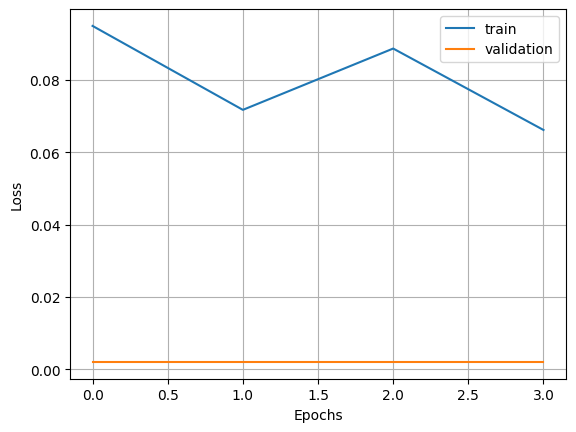

In [6]:
from losses.atomic_fact_loss import AtomicFactsLoss


optimizer = optim.AdamW(verification_model.parameters(), lr=1e-7)
criterion = AtomicFactsLoss() #BCELoss()

timestamp = datetime.now().strftime("%m-%d_%H-%M")

num_epochs = 10 
patience = 3   
gradient_accumulation = 64
trace_train = []
trace_val = []

verification_model.zero_grad()
use_amp = True
scaler = GradScaler(enabled=use_amp, init_scale=1)

#checkpoint = torch.load(f'training_05-15_15-55')
#optimizer.load_state_dict(checkpoint['optimizer'])
#scaler.load_state_dict(checkpoint['scaler'])

best_loss = np.inf
for epoch in range(num_epochs):
    bar_desc = "Epoch %d of %d | Iteration" % (epoch + 1, num_epochs)
    train_iterator = tqdm(train_dataloader, desc=bar_desc)

    train_loss = 0
    print('Train ...')
    for step, batch in enumerate(train_iterator):
        verification_model.train()
        model_input = batch["model_input"]
        claim_mask = model_input.get('claim_mask')

        with autocast():
            logits = verification_model(input_ids=model_input['input_ids'], 
                                        attention_mask=model_input['attention_mask'])['logits']
            predicted = torch.softmax(logits, dim=-1)
            #predicted[:, 1] += predicted[:, 2]
            predicted = predicted[:, :1]
            labels = batch['labels']
            #labels_one_hot = torch.zeros_like(predicted)
            #labels_one_hot.scatter_(1, batch['labels'].unsqueeze(1), 1)
            loss = criterion(labels, predicted, claim_mask)
            train_loss += loss.detach().item()
            loss = (loss / gradient_accumulation)
        scaler.scale(loss).backward()

        if (step + 1) % gradient_accumulation == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1) #1e-2

            scaler.step(optimizer)
            scaler.update()
            optimizer.step()
            optimizer.zero_grad()

    trace_train.append(train_loss / len(train_dataloader))
    # validation
    with torch.no_grad():
        val_loss, report = evaluate(verification_model, dev_dataloader, criterion)
        trace_val.append(val_loss)
        print(
            f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {(train_loss / len(train_dataloader)):.4f}, Validation Loss: {val_loss:.4f}')
        print(report)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            best_state = {key: value.cpu() for key, value in
                          verification_model.state_dict().items()}
            verification_model.save(f'verification_model_intermediate_{timestamp}')
            torch.save({
                'optimizer': optimizer.state_dict(),
                'scaler': scaler.state_dict()}, f'training_{timestamp}')
        else:
            if epoch >= best_epoch + patience:
                break

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            best_state.clear() 
            for key, value in verification_model.state_dict().items():
                best_state[key].copy_(value.cpu())
            verification_model.save(f'selection_model_intermediate_{timestamp}')
        else:
            if epoch >= best_epoch + patience:
                break

verification_model.load_state_dict(best_state)
verification_model.save(f'selection_model_{timestamp}')
torch.save({'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict()}, f'training_{timestamp}')

plt.plot(trace_train, label='train')
plt.plot(trace_val, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

In [17]:
from losses.atomic_fact_loss import AtomicFactsLoss

criterion = AtomicFactsLoss() #BCELoss()
val_loss, report = evaluate(verification_model, train_dataloader, criterion)
print(val_loss)
print(report)

100%|██████████| 36/36 [02:16<00:00,  3.79s/it]

0.0768919289112091
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       180
           1       0.96      0.97      0.97       395

    accuracy                           0.95       575
   macro avg       0.95      0.95      0.95       575
weighted avg       0.95      0.95      0.95       575



In [ ]:
test_dataset_raw = Dataset.from_sql(dataset_query.format(set_type='test'), con=DB_URL)
test_dataset = DefinitionDataset(test_dataset_raw, tokenizer, mode='train', model='evidence_selection')
test_dataloader = DataLoader(test_dataset, shuffle=True, collate_fn=test_dataset.collate_fn, batch_size=10)

test_loss, report = evaluate(model, test_dataloader)
print(test_loss)
print(report)